In [2]:
import pandas as pd

# Load the dataset (modify the filename as needed)
file_path = "C:/Users/Evan Ji/Downloads/archive/ddos_balanced/final_dataset.csv" 
df = pd.read_csv(file_path)


sample_fraction = 0.001  

# Randomly sample the dataset
df_sampled = df.sample(frac=sample_fraction, random_state=42)  

# Save the sampled dataset to a new file
output_file = "sampled_dataset.csv"
df_sampled.to_csv(output_file, index=False)

print(f"Sampled dataset saved as {output_file}")
print(f"Sampled dataset size: {df_sampled.shape[0]} rows × {df_sampled.shape[1]} columns")



Sampled dataset saved as sampled_dataset.csv
Sampled dataset size: 12795 rows × 85 columns


for sample size testing logistic regression

In [21]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load dataset
file_path = "sampled_dataset.csv"
df = pd.read_csv(file_path)

# Drop non-feature columns
drop_columns = ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label","Unnamed: 0"]
df_clean = df.drop(columns=drop_columns, errors="ignore")

# Clean data
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.fillna(df_clean.median(), inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])
y = df["Label"]

# CSV output path
output_csv = "logistic_regression_feature_comparison_incremental.csv"

# Write header if file doesn't exist
if not os.path.exists(output_csv):
    pd.DataFrame(columns=[
        "Num_Features", "Sample_Size",
        "Train_Preprocessing_Time_sec", "Model_Train_Time_sec", "Test_Inference_Time_sec",
        "Accuracy", "Precision", "Recall", "F1_Score",
        "TN", "FP", "FN", "TP"
    ]).to_csv(output_csv, index=False)

# Loop through feature counts
for num_features in range(5, len(df_clean.columns) + 1, 1):
    print(f"➡️  Running model with top {num_features} features...")

    X_subset = df_clean.iloc[:, :num_features]

    # Train-test split and scaling
    pre_start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    train_preprocessing_time = time.time() - pre_start_time

    # Model training
    model = LogisticRegression(max_iter=500)
    train_start_time = time.time()
    model.fit(X_train_scaled, y_train)
    model_train_time = time.time() - train_start_time

    # Inference on test set
    test_start_time = time.time()
    y_pred = model.predict(X_test_scaled)
    test_inference_time = time.time() - test_start_time

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sample_size = len(y)

    # Result row
    row = pd.DataFrame([{
        "Num_Features": num_features,
        "Sample_Size": sample_size,
        "Train_Preprocessing_Time_sec": train_preprocessing_time,
        "Model_Train_Time_sec": model_train_time,
        "Test_Inference_Time_sec": test_inference_time,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    }])

    # Save to CSV
    row.to_csv(output_csv, mode="a", index=False, header=not os.path.exists(output_csv))

    print(f"✅ {num_features} features | Acc: {acc:.4f} | F1: {f1:.4f} | Inference: {test_inference_time:.3f}s")



➡️  Running model with top 5 features...
✅ 5 features | Acc: 0.7237 | F1: 0.7783 | Inference: 0.002s
➡️  Running model with top 6 features...
✅ 6 features | Acc: 0.7726 | F1: 0.8113 | Inference: 0.001s
➡️  Running model with top 7 features...
✅ 7 features | Acc: 0.7741 | F1: 0.8123 | Inference: 0.000s
➡️  Running model with top 8 features...
✅ 8 features | Acc: 0.7730 | F1: 0.8118 | Inference: 0.000s
➡️  Running model with top 9 features...
✅ 9 features | Acc: 0.8488 | F1: 0.8602 | Inference: 0.000s
➡️  Running model with top 10 features...
✅ 10 features | Acc: 0.8499 | F1: 0.8613 | Inference: 0.000s
➡️  Running model with top 11 features...
✅ 11 features | Acc: 0.8710 | F1: 0.8801 | Inference: 0.000s
➡️  Running model with top 12 features...
✅ 12 features | Acc: 0.9074 | F1: 0.9150 | Inference: 0.000s
➡️  Running model with top 13 features...
✅ 13 features | Acc: 0.8976 | F1: 0.9048 | Inference: 0.000s
➡️  Running model with top 14 features...
✅ 14 features | Acc: 0.8972 | F1: 0.9046 

netflow vs netflow extended vs both

In [1]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# === CONFIG ===
file_path = "sampled_dataset.csv"
output_files = {
    "netflow": "logreg_netflow.csv",
    "netflow_extended": "logreg_netflow_extended.csv"
}
output_columns = [
    "Num_Features", "Sample_Size",
    "Train_Preprocessing_Time_sec", "Model_Train_Time_sec", "Test_Inference_Time_sec",
    "Accuracy", "Precision", "Recall", "F1_Score",
    "TN", "FP", "FN", "TP"
]

# === LOAD DATA ===
df = pd.read_csv(file_path)
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])
y = df["Label"]

# Drop non-feature columns
drop_columns = ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label"]
df_clean = df.drop(columns=drop_columns, errors="ignore")

# === DEFINE FEATURE GROUPS ===
netflow_features = [
    "Flow Duration", "Tot Fwd Pkts", "Tot Bwd Pkts", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Fwd Pkt Len Max", "Fwd Pkt Len Min", "Fwd Pkt Len Mean", "Fwd Pkt Len Std",
    "Bwd Pkt Len Max", "Bwd Pkt Len Min", "Bwd Pkt Len Mean", "Bwd Pkt Len Std",
    "Flow Byts/s", "Flow Pkts/s"
]

netflow_extended_features = [
    "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min",
    "Fwd IAT Tot", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min",
    "Bwd IAT Tot", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min",
    "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags",
    "Fwd Header Len", "Bwd Header Len", "Fwd Pkts/s", "Bwd Pkts/s",
    "Pkt Len Min", "Pkt Len Max", "Pkt Len Mean", "Pkt Len Std", "Pkt Len Var",
    "FIN Flag Cnt", "SYN Flag Cnt", "RST Flag Cnt", "PSH Flag Cnt", "ACK Flag Cnt", "URG Flag Cnt",
    "CWE Flag Count", "ECE Flag Cnt", "Down/Up Ratio", "Pkt Size Avg",
    "Fwd Seg Size Avg", "Bwd Seg Size Avg", "Fwd Byts/b Avg", "Fwd Pkts/b Avg", "Fwd Blk Rate Avg",
    "Bwd Byts/b Avg", "Bwd Pkts/b Avg", "Bwd Blk Rate Avg", "Subflow Fwd Pkts", "Subflow Fwd Byts",
    "Subflow Bwd Pkts", "Subflow Bwd Byts", "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Act Data Pkts", "Fwd Seg Size Min", "Active Mean", "Active Std", "Active Max", "Active Min",
    "Idle Mean", "Idle Std", "Idle Max", "Idle Min"
]

feature_groups = {
    "netflow": netflow_features,
    "netflow_extended": netflow_extended_features
}

# === MAIN LOOP ===
for group_name, features in feature_groups.items():
    output_csv = output_files[group_name]

    # Create CSV with header if needed
    if not os.path.exists(output_csv):
        pd.DataFrame(columns=output_columns).to_csv(output_csv, index=False)

    print(f"\n🔎 Running Logistic Regression on: {group_name.replace('_', ' ').title()}")

    # Filter features
    current_df = df_clean[features].copy()

    # Clean up data
    current_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    current_df.fillna(current_df.median(), inplace=True)

    # Loop through number of features
    for num_features in range(1, len(current_df.columns) + 1):
        X_subset = current_df.iloc[:, :num_features]
        print(f"➡️  {group_name} | Top {num_features} features...")

        # Train/test split and scale
        pre_start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42, stratify=y)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        train_preprocessing_time = time.time() - pre_start_time

        # Train model
        model = LogisticRegression(max_iter=500)
        train_start_time = time.time()
        model.fit(X_train_scaled, y_train)
        model_train_time = time.time() - train_start_time

        # Inference
        test_start_time = time.time()
        y_pred = model.predict(X_test_scaled)
        test_inference_time = time.time() - test_start_time

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sample_size = len(y)

        # Save result
        row = pd.DataFrame([{
            "Num_Features": num_features,
            "Sample_Size": sample_size,
            "Train_Preprocessing_Time_sec": train_preprocessing_time,
            "Model_Train_Time_sec": model_train_time,
            "Test_Inference_Time_sec": test_inference_time,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1_Score": f1,
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "TP": tp
        }])
        row.to_csv(output_csv, mode="a", index=False, header=False)

        print(f"✅ {num_features} features | Acc: {acc:.4f} | F1: {f1:.4f}")



🔎 Running Logistic Regression on: Netflow
➡️  netflow | Top 1 features...
✅ 1 features | Acc: 0.5584 | F1: 0.6845
➡️  netflow | Top 2 features...
✅ 2 features | Acc: 0.5584 | F1: 0.6845
➡️  netflow | Top 3 features...
✅ 3 features | Acc: 0.5881 | F1: 0.6925
➡️  netflow | Top 4 features...
✅ 4 features | Acc: 0.5807 | F1: 0.6796
➡️  netflow | Top 5 features...
✅ 5 features | Acc: 0.5807 | F1: 0.6798
➡️  netflow | Top 6 features...
✅ 6 features | Acc: 0.6182 | F1: 0.5367
➡️  netflow | Top 7 features...
✅ 7 features | Acc: 0.7972 | F1: 0.8183
➡️  netflow | Top 8 features...
✅ 8 features | Acc: 0.8245 | F1: 0.8428
➡️  netflow | Top 9 features...
✅ 9 features | Acc: 0.8398 | F1: 0.8597
➡️  netflow | Top 10 features...
✅ 10 features | Acc: 0.8363 | F1: 0.8564
➡️  netflow | Top 11 features...
✅ 11 features | Acc: 0.8429 | F1: 0.8620
➡️  netflow | Top 12 features...
✅ 12 features | Acc: 0.8441 | F1: 0.8630
➡️  netflow | Top 13 features...
✅ 13 features | Acc: 0.8453 | F1: 0.8643
➡️  netflow |

 sample size testing rf 

In [11]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load dataset
file_path = "sampled_dataset.csv"
df = pd.read_csv(file_path)

# Drop non-feature columns
drop_columns = ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label","Unnamed: 0"]
df_clean = df.drop(columns=drop_columns, errors="ignore")

# Clean data
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.fillna(df_clean.median(), inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])
y = df["Label"]

# CSV output path
output_csv = "random_forest_feature_comparison_incremental.csv"

# Write header if file doesn't exist
if not os.path.exists(output_csv):
    pd.DataFrame(columns=[
        "Num_Features", "Sample_Size",
        "Train_Preprocessing_Time_sec", "Model_Train_Time_sec", "Test_Inference_Time_sec",
        "Accuracy", "Precision", "Recall", "F1_Score",
        "TN", "FP", "FN", "TP"
    ]).to_csv(output_csv, index=False)

# Loop through feature counts
for num_features in range(5, len(df_clean.columns) + 1, 1):
    print(f"🌲 Running Random Forest with top {num_features} features...")

    X_subset = df_clean.iloc[:, :num_features]

    # Train-test split and scaling
    pre_start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    train_preprocessing_time = time.time() - pre_start_time

    # Model training
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    train_start_time = time.time()
    rf_model.fit(X_train_scaled, y_train)
    model_train_time = time.time() - train_start_time

    # Inference
    test_start_time = time.time()
    y_pred = rf_model.predict(X_test_scaled)
    test_inference_time = time.time() - test_start_time

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sample_size = len(y)

    # Result row
    row = pd.DataFrame([{
        "Num_Features": num_features,
        "Sample_Size": sample_size,
        "Train_Preprocessing_Time_sec": train_preprocessing_time,
        "Model_Train_Time_sec": model_train_time,
        "Test_Inference_Time_sec": test_inference_time,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    }])

    # Save to CSV
    row.to_csv(output_csv, mode="a", index=False, header=not os.path.exists(output_csv))

    print(f"✅ {num_features} features | Acc: {acc:.4f} | F1: {f1:.4f} | Inference: {test_inference_time:.3f}s")


🌲 Running Random Forest with top 5 features...
✅ 5 features | Acc: 0.9934 | F1: 0.9934 | Inference: 0.021s
🌲 Running Random Forest with top 6 features...
✅ 6 features | Acc: 0.9965 | F1: 0.9965 | Inference: 0.020s
🌲 Running Random Forest with top 7 features...
✅ 7 features | Acc: 0.9969 | F1: 0.9969 | Inference: 0.020s
🌲 Running Random Forest with top 8 features...
✅ 8 features | Acc: 0.9977 | F1: 0.9977 | Inference: 0.020s
🌲 Running Random Forest with top 9 features...
✅ 9 features | Acc: 0.9980 | F1: 0.9981 | Inference: 0.038s
🌲 Running Random Forest with top 10 features...
✅ 10 features | Acc: 0.9984 | F1: 0.9985 | Inference: 0.020s
🌲 Running Random Forest with top 11 features...
✅ 11 features | Acc: 0.9977 | F1: 0.9977 | Inference: 0.024s
🌲 Running Random Forest with top 12 features...
✅ 12 features | Acc: 0.9977 | F1: 0.9977 | Inference: 0.022s
🌲 Running Random Forest with top 13 features...
✅ 13 features | Acc: 0.9973 | F1: 0.9973 | Inference: 0.022s
🌲 Running Random Forest with 

In [ ]:
import pandas as pd
import numpy as np
import time
import os
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


file_path = "sampled_dataset.csv"
output_csv = "all_3feature_combination_results.csv"
subset_size = 3

df = pd.read_csv(file_path)
drop_columns = ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label", "Unnamed: 0"]
df_clean = df.drop(columns=drop_columns, errors="ignore")
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.fillna(df_clean.median(), inplace=True)

# Encode target
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])
y = df["Label"]
sample_size = len(y)
feature_names = df_clean.columns.tolist()


if not os.path.exists(output_csv):
    pd.DataFrame(columns=[
        "Model", "Feature_Set", "Num_Features", "Sample_Size",
        "Train_Preprocessing_Time_sec", "Model_Train_Time_sec", "Test_Inference_Time_sec",
        "Accuracy", "Precision", "Recall", "F1_Score",
        "TN", "FP", "FN", "TP"
    ]).to_csv(output_csv, index=False)

all_combos = list(combinations(feature_names, subset_size))
total = len(all_combos)

for idx, combo in enumerate(all_combos):
    print(f"\n🔁 [{idx+1}/{total}] Features: {combo}")

    X_subset = df_clean[list(combo)]
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42, stratify=y)

    # Standardize
    scaler = StandardScaler()
    pre_start = time.time()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    pre_time = time.time() - pre_start

    for model_type in ["LogisticRegression", "RandomForest"]:
        if model_type == "LogisticRegression":
            model = LogisticRegression(max_iter=1000)
        else:
            model = RandomForestClassifier(n_estimators=100, random_state=42)

        train_start = time.time()
        model.fit(X_train_scaled, y_train)
        train_time = time.time() - train_start

        test_start = time.time()
        y_pred = model.predict(X_test_scaled)
        test_time = time.time() - test_start

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        row = pd.DataFrame([{
            "Model": model_type,
            "Feature_Set": ",".join(combo),
            "Num_Features": subset_size,
            "Sample_Size": sample_size,
            "Train_Preprocessing_Time_sec": pre_time,
            "Model_Train_Time_sec": train_time,
            "Test_Inference_Time_sec": test_time,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1_Score": f1,
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "TP": tp
        }])
        row.to_csv(output_csv, mode="a", index=False, header=False)

        print(f"✅ {model_type} | Acc: {acc:.4f} | F1: {f1:.4f}")



🔁 [1/79079] Features: ('Src Port', 'Dst Port', 'Protocol')
✅ LogisticRegression | Acc: 0.6565 | F1: 0.7321
✅ RandomForest | Acc: 0.9242 | F1: 0.9253

🔁 [2/79079] Features: ('Src Port', 'Dst Port', 'Flow Duration')
✅ LogisticRegression | Acc: 0.6514 | F1: 0.5882
✅ RandomForest | Acc: 0.9793 | F1: 0.9795

🔁 [3/79079] Features: ('Src Port', 'Dst Port', 'Tot Fwd Pkts')
✅ LogisticRegression | Acc: 0.6131 | F1: 0.5259
✅ RandomForest | Acc: 0.9660 | F1: 0.9663

🔁 [4/79079] Features: ('Src Port', 'Dst Port', 'Tot Bwd Pkts')
✅ LogisticRegression | Acc: 0.6174 | F1: 0.5286
✅ RandomForest | Acc: 0.9683 | F1: 0.9687

🔁 [5/79079] Features: ('Src Port', 'Dst Port', 'TotLen Fwd Pkts')
✅ LogisticRegression | Acc: 0.6131 | F1: 0.5259
✅ RandomForest | Acc: 0.9574 | F1: 0.9579

🔁 [6/79079] Features: ('Src Port', 'Dst Port', 'TotLen Bwd Pkts')
✅ LogisticRegression | Acc: 0.6147 | F1: 0.5269
✅ RandomForest | Acc: 0.9597 | F1: 0.9602

🔁 [7/79079] Features: ('Src Port', 'Dst Port', 'Fwd Pkt Len Max')
✅ Logi

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# === CONFIG ===
file_path = "C:/Users/Evan Ji/Downloads/archive/ddos_balanced/final_dataset.csv"
sample_fractions = [0.01, 0.001]
models = {
    "extratrees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}
output_template = "{}.csv"  # will become extratrees.csv, mlpclassifier.csv

# === COLUMNS FOR OUTPUT ===
output_columns = [
    "Num_Features", "Sample_Size",
    "Train_Preprocessing_Time_sec", "Model_Train_Time_sec", "Test_Inference_Time_sec",
    "Accuracy", "Precision", "Recall", "F1_Score",
    "TN", "FP", "FN", "TP"
]

# === MAIN LOOP ===
for model_name, model_prototype in models.items():
    output_csv = output_template.format(model_name)

    # Write header if not exists
    if not os.path.exists(output_csv):
        pd.DataFrame(columns=output_columns).to_csv(output_csv, index=False)

    for sample_fraction in sample_fractions:
        print(f"\n📏 [{model_name}] Sampling {sample_fraction * 100:.1f}% of dataset")

        # Load & sample data
        df = pd.read_csv(file_path)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)

        df_sampled = df.sample(frac=sample_fraction, random_state=42)
        sample_size = len(df_sampled)

        # Encode target
        label_encoder = LabelEncoder()
        df_sampled["Label"] = label_encoder.fit_transform(df_sampled["Label"])
        y = df_sampled["Label"]

        # Clean features
        drop_columns = ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label"]
        df_clean = df_sampled.drop(columns=drop_columns, errors="ignore")
        df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_clean.fillna(df_clean.median(), inplace=True)
        feature_names = df_clean.columns.tolist()

        for num_features in range(1, len(feature_names) + 1):
            print(f"➡️ [{model_name}] Sample: {sample_fraction} | Features: {num_features}")

            X_subset = df_clean.iloc[:, :num_features]

            # Train-test split and scale
            pre_start = time.time()
            X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42, stratify=y)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            pre_time = time.time() - pre_start

            # Clone model fresh each run
            model = model_prototype.__class__(**model_prototype.get_params())

            # Train model
            train_start = time.time()
            model.fit(X_train_scaled, y_train)
            train_time = time.time() - train_start

            # Predict
            test_start = time.time()
            y_pred = model.predict(X_test_scaled)
            test_time = time.time() - test_start

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            # Save row
            row = pd.DataFrame([{
                "Num_Features": num_features,
                "Sample_Size": sample_size,
                "Train_Preprocessing_Time_sec": pre_time,
                "Model_Train_Time_sec": train_time,
                "Test_Inference_Time_sec": test_time,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1_Score": f1,
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "TP": tp
            }])
            row.to_csv(output_csv, mode="a", index=False, header=False)

            print(f"✅ {model_name} | Features: {num_features} | F1: {f1:.4f} | Acc: {acc:.4f}")



📏 [extratrees] Sampling 1.0% of dataset
➡️ [extratrees] Sample: 0.01 | Features: 1
✅ extratrees | Features: 1 | F1: 0.7303 | Acc: 0.7435
➡️ [extratrees] Sample: 0.01 | Features: 2
✅ extratrees | Features: 2 | F1: 0.9211 | Acc: 0.9207
➡️ [extratrees] Sample: 0.01 | Features: 3
✅ extratrees | Features: 3 | F1: 0.9214 | Acc: 0.9211
➡️ [extratrees] Sample: 0.01 | Features: 4
✅ extratrees | Features: 4 | F1: 0.9829 | Acc: 0.9827
➡️ [extratrees] Sample: 0.01 | Features: 5
✅ extratrees | Features: 5 | F1: 0.9952 | Acc: 0.9951
➡️ [extratrees] Sample: 0.01 | Features: 6
✅ extratrees | Features: 6 | F1: 0.9974 | Acc: 0.9973
➡️ [extratrees] Sample: 0.01 | Features: 7
✅ extratrees | Features: 7 | F1: 0.9978 | Acc: 0.9978
➡️ [extratrees] Sample: 0.01 | Features: 8
✅ extratrees | Features: 8 | F1: 0.9978 | Acc: 0.9978
➡️ [extratrees] Sample: 0.01 | Features: 9
✅ extratrees | Features: 9 | F1: 0.9981 | Acc: 0.9980
➡️ [extratrees] Sample: 0.01 | Features: 10
✅ extratrees | Features: 10 | F1: 0.9979 |

c:\Users\Evan Ji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


✅ mlpclassifier | Features: 6 | F1: 0.9817 | Acc: 0.9814
➡️ [mlpclassifier] Sample: 0.01 | Features: 7


In [2]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# === CONFIG ===
file_path = "C:/Users/Evan Ji/Downloads/archive/ddos_balanced/final_dataset.csv"
sample_fractions = [0.001, 0.0001]
models = {
    "mlpclassifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}
output_template = "{}.csv"  

# === COLUMNS FOR OUTPUT ===
output_columns = [
    "Num_Features", "Sample_Size",
    "Train_Preprocessing_Time_sec", "Model_Train_Time_sec", "Test_Inference_Time_sec",
    "Accuracy", "Precision", "Recall", "F1_Score",
    "TN", "FP", "FN", "TP"
]

# === MAIN LOOP ===
for model_name, model_prototype in models.items():
    output_csv = output_template.format(model_name)

    # Write header if not exists
    if not os.path.exists(output_csv):
        pd.DataFrame(columns=output_columns).to_csv(output_csv, index=False)

    for sample_fraction in sample_fractions:
        print(f"\n📏 [{model_name}] Sampling {sample_fraction * 100:.1f}% of dataset")

        # Load & sample data
        df = pd.read_csv(file_path)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)

        df_sampled = df.sample(frac=sample_fraction, random_state=42)
        sample_size = len(df_sampled)

        # Encode target
        label_encoder = LabelEncoder()
        df_sampled["Label"] = label_encoder.fit_transform(df_sampled["Label"])
        y = df_sampled["Label"]

        # Clean features
        drop_columns = ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label"]
        df_clean = df_sampled.drop(columns=drop_columns, errors="ignore")
        df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_clean.fillna(df_clean.median(), inplace=True)
        feature_names = df_clean.columns.tolist()

        for num_features in range(1, len(feature_names) + 1,3):
            print(f"➡️ [{model_name}] Sample: {sample_fraction} | Features: {num_features}")

            X_subset = df_clean.iloc[:, :num_features]

            # Train-test split and scale
            pre_start = time.time()
            X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42, stratify=y)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            pre_time = time.time() - pre_start

            # Clone model fresh each run
            model = model_prototype.__class__(**model_prototype.get_params())

            # Train model
            train_start = time.time()
            model.fit(X_train_scaled, y_train)
            train_time = time.time() - train_start

            # Predict
            test_start = time.time()
            y_pred = model.predict(X_test_scaled)
            test_time = time.time() - test_start

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            # Save row
            row = pd.DataFrame([{
                "Num_Features": num_features,
                "Sample_Size": sample_size,
                "Train_Preprocessing_Time_sec": pre_time,
                "Model_Train_Time_sec": train_time,
                "Test_Inference_Time_sec": test_time,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1_Score": f1,
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "TP": tp
            }])
            row.to_csv(output_csv, mode="a", index=False, header=False)

            print(f"✅ {model_name} | Features: {num_features} | F1: {f1:.4f} | Acc: {acc:.4f}")



📏 [mlpclassifier] Sampling 0.1% of dataset
➡️ [mlpclassifier] Sample: 0.001 | Features: 1
✅ mlpclassifier | Features: 1 | F1: 0.6909 | Acc: 0.7007
➡️ [mlpclassifier] Sample: 0.001 | Features: 4
✅ mlpclassifier | Features: 4 | F1: 0.8886 | Acc: 0.8867
➡️ [mlpclassifier] Sample: 0.001 | Features: 7


c:\Users\Evan Ji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ mlpclassifier | Features: 7 | F1: 0.9632 | Acc: 0.9625
➡️ [mlpclassifier] Sample: 0.001 | Features: 10


c:\Users\Evan Ji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ mlpclassifier | Features: 10 | F1: 0.9768 | Acc: 0.9762
➡️ [mlpclassifier] Sample: 0.001 | Features: 13
✅ mlpclassifier | Features: 13 | F1: 0.9779 | Acc: 0.9773
➡️ [mlpclassifier] Sample: 0.001 | Features: 16
✅ mlpclassifier | Features: 16 | F1: 0.9794 | Acc: 0.9789
➡️ [mlpclassifier] Sample: 0.001 | Features: 19
✅ mlpclassifier | Features: 19 | F1: 0.9824 | Acc: 0.9820
➡️ [mlpclassifier] Sample: 0.001 | Features: 22
✅ mlpclassifier | Features: 22 | F1: 0.9911 | Acc: 0.9910
➡️ [mlpclassifier] Sample: 0.001 | Features: 25


c:\Users\Evan Ji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ mlpclassifier | Features: 25 | F1: 0.9911 | Acc: 0.9910
➡️ [mlpclassifier] Sample: 0.001 | Features: 28
✅ mlpclassifier | Features: 28 | F1: 0.9839 | Acc: 0.9836
➡️ [mlpclassifier] Sample: 0.001 | Features: 31
✅ mlpclassifier | Features: 31 | F1: 0.9892 | Acc: 0.9891
➡️ [mlpclassifier] Sample: 0.001 | Features: 34
✅ mlpclassifier | Features: 34 | F1: 0.9884 | Acc: 0.9883
➡️ [mlpclassifier] Sample: 0.001 | Features: 37
✅ mlpclassifier | Features: 37 | F1: 0.9888 | Acc: 0.9887
➡️ [mlpclassifier] Sample: 0.001 | Features: 40
✅ mlpclassifier | Features: 40 | F1: 0.9907 | Acc: 0.9906
➡️ [mlpclassifier] Sample: 0.001 | Features: 43
✅ mlpclassifier | Features: 43 | F1: 0.9915 | Acc: 0.9914
➡️ [mlpclassifier] Sample: 0.001 | Features: 46
✅ mlpclassifier | Features: 46 | F1: 0.9873 | Acc: 0.9871
➡️ [mlpclassifier] Sample: 0.001 | Features: 49
✅ mlpclassifier | Features: 49 | F1: 0.9919 | Acc: 0.9918
➡️ [mlpclassifier] Sample: 0.001 | Features: 52
✅ mlpclassifier | Features: 52 | F1: 0.9930 | 

c:\Users\Evan Ji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ mlpclassifier | Features: 4 | F1: 0.8176 | Acc: 0.7891
➡️ [mlpclassifier] Sample: 0.0001 | Features: 7
✅ mlpclassifier | Features: 7 | F1: 0.9615 | Acc: 0.9609
➡️ [mlpclassifier] Sample: 0.0001 | Features: 10


c:\Users\Evan Ji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ mlpclassifier | Features: 10 | F1: 0.9766 | Acc: 0.9766
➡️ [mlpclassifier] Sample: 0.0001 | Features: 13


c:\Users\Evan Ji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ mlpclassifier | Features: 13 | F1: 0.9653 | Acc: 0.9648
➡️ [mlpclassifier] Sample: 0.0001 | Features: 16
✅ mlpclassifier | Features: 16 | F1: 0.9728 | Acc: 0.9727
➡️ [mlpclassifier] Sample: 0.0001 | Features: 19


c:\Users\Evan Ji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ mlpclassifier | Features: 19 | F1: 0.9804 | Acc: 0.9805
➡️ [mlpclassifier] Sample: 0.0001 | Features: 22
✅ mlpclassifier | Features: 22 | F1: 0.9881 | Acc: 0.9883
➡️ [mlpclassifier] Sample: 0.0001 | Features: 25


c:\Users\Evan Ji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ mlpclassifier | Features: 25 | F1: 0.9843 | Acc: 0.9844
➡️ [mlpclassifier] Sample: 0.0001 | Features: 28
✅ mlpclassifier | Features: 28 | F1: 0.9804 | Acc: 0.9805
➡️ [mlpclassifier] Sample: 0.0001 | Features: 31
✅ mlpclassifier | Features: 31 | F1: 0.9881 | Acc: 0.9883
➡️ [mlpclassifier] Sample: 0.0001 | Features: 34
✅ mlpclassifier | Features: 34 | F1: 0.9881 | Acc: 0.9883
➡️ [mlpclassifier] Sample: 0.0001 | Features: 37
✅ mlpclassifier | Features: 37 | F1: 0.9766 | Acc: 0.9766
➡️ [mlpclassifier] Sample: 0.0001 | Features: 40
✅ mlpclassifier | Features: 40 | F1: 0.9881 | Acc: 0.9883
➡️ [mlpclassifier] Sample: 0.0001 | Features: 43
✅ mlpclassifier | Features: 43 | F1: 0.9804 | Acc: 0.9805
➡️ [mlpclassifier] Sample: 0.0001 | Features: 46
✅ mlpclassifier | Features: 46 | F1: 0.9881 | Acc: 0.9883
➡️ [mlpclassifier] Sample: 0.0001 | Features: 49
✅ mlpclassifier | Features: 49 | F1: 0.9921 | Acc: 0.9922
➡️ [mlpclassifier] Sample: 0.0001 | Features: 52
✅ mlpclassifier | Features: 52 | F1: 

In [3]:

import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE

# Load dataset
file_path = "sampled_dataset.csv"
df = pd.read_csv(file_path)
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Encode label
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])
y = df["Label"]

# Drop non-feature columns
drop_columns = ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label"]
df_clean = df.drop(columns=drop_columns, errors="ignore")

# Define NetFlow and NetFlow Extended features
netflow_features = [
    "Flow Duration", "Tot Fwd Pkts", "Tot Bwd Pkts", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Fwd Pkt Len Max", "Fwd Pkt Len Min", "Fwd Pkt Len Mean", "Fwd Pkt Len Std",
    "Bwd Pkt Len Max", "Bwd Pkt Len Min", "Bwd Pkt Len Mean", "Bwd Pkt Len Std",
    "Flow Byts/s", "Flow Pkts/s"
]

netflow_extended_features = [
    "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min",
    "Fwd IAT Tot", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min",
    "Bwd IAT Tot", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min",
    "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags",
    "Fwd Header Len", "Bwd Header Len", "Fwd Pkts/s", "Bwd Pkts/s",
    "Pkt Len Min", "Pkt Len Max", "Pkt Len Mean", "Pkt Len Std", "Pkt Len Var",
    "FIN Flag Cnt", "SYN Flag Cnt", "RST Flag Cnt", "PSH Flag Cnt", "ACK Flag Cnt", "URG Flag Cnt",
    "CWE Flag Count", "ECE Flag Cnt", "Down/Up Ratio", "Pkt Size Avg",
    "Fwd Seg Size Avg", "Bwd Seg Size Avg", "Fwd Byts/b Avg", "Fwd Pkts/b Avg", "Fwd Blk Rate Avg",
    "Bwd Byts/b Avg", "Bwd Pkts/b Avg", "Bwd Blk Rate Avg", "Subflow Fwd Pkts", "Subflow Fwd Byts",
    "Subflow Bwd Pkts", "Subflow Bwd Byts", "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Act Data Pkts", "Fwd Seg Size Min", "Active Mean", "Active Std", "Active Max", "Active Min",
    "Idle Mean", "Idle Std", "Idle Max", "Idle Min"
]

feature_groups = {
    "netflow": netflow_features,
    "netflow_extended": netflow_extended_features
}

# Shared output structure
columns = [
    "Num_Features", "Sample_Size",
    "Train_Preprocessing_Time_sec", "Model_Train_Time_sec", "Test_Inference_Time_sec",
    "Accuracy", "Precision", "Recall", "F1_Score",
    "TN", "FP", "FN", "TP", "Selected_Features"
]

# Loop through both feature sets
for feature_set_name, features in feature_groups.items():
    print(f"\n🔍 Running RFE Logistic Regression for: {feature_set_name}")

    output_csv = f"logreg_rfe_backwards_{feature_set_name}.csv"

    # Prepare data
    df_features = df_clean[features].copy()
    df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_features.fillna(df_features.median(), inplace=True)

    # Write header to CSV
    if not os.path.exists(output_csv):
        pd.DataFrame(columns=columns).to_csv(output_csv, index=False)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42, stratify=y)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # RFE loop (backward selection)
    for n_features in range(len(features), 0, -1):
        print(f"🔁 RFE with top {n_features} features...")

        pre_start = time.time()
        model = LogisticRegression(max_iter=500, solver='liblinear')
        rfe = RFE(model, n_features_to_select=n_features)
        rfe.fit(X_train_scaled, y_train)

        selected_indices = rfe.get_support(indices=True)
        selected_features = df_features.columns[selected_indices].tolist()

        X_train_sel = rfe.transform(X_train_scaled)
        X_test_sel = rfe.transform(X_test_scaled)
        pre_time = time.time() - pre_start

        train_start = time.time()
        model.fit(X_train_sel, y_train)
        train_time = time.time() - train_start

        test_start = time.time()
        y_pred = model.predict(X_test_sel)
        test_time = time.time() - test_start

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        row = pd.DataFrame([{
            "Num_Features": n_features,
            "Sample_Size": len(y),
            "Train_Preprocessing_Time_sec": pre_time,
            "Model_Train_Time_sec": train_time,
            "Test_Inference_Time_sec": test_time,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1_Score": f1,
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "TP": tp,
            "Selected_Features": ",".join(selected_features)
        }])
        row.to_csv(output_csv, mode="a", index=False, header=False)

output_paths = [f"logreg_rfe_backwards_{name}.csv" for name in feature_groups]
output_paths



🔍 Running RFE Logistic Regression for: netflow
🔁 RFE with top 15 features...
🔁 RFE with top 14 features...
🔁 RFE with top 13 features...
🔁 RFE with top 12 features...
🔁 RFE with top 11 features...
🔁 RFE with top 10 features...
🔁 RFE with top 9 features...
🔁 RFE with top 8 features...
🔁 RFE with top 7 features...
🔁 RFE with top 6 features...
🔁 RFE with top 5 features...
🔁 RFE with top 4 features...
🔁 RFE with top 3 features...
🔁 RFE with top 2 features...
🔁 RFE with top 1 features...

🔍 Running RFE Logistic Regression for: netflow_extended
🔁 RFE with top 61 features...
🔁 RFE with top 60 features...
🔁 RFE with top 59 features...
🔁 RFE with top 58 features...
🔁 RFE with top 57 features...
🔁 RFE with top 56 features...
🔁 RFE with top 55 features...
🔁 RFE with top 54 features...
🔁 RFE with top 53 features...
🔁 RFE with top 52 features...
🔁 RFE with top 51 features...
🔁 RFE with top 50 features...
🔁 RFE with top 49 features...
🔁 RFE with top 48 features...
🔁 RFE with top 47 features...
🔁 RF

['logreg_rfe_backwards_netflow.csv',
 'logreg_rfe_backwards_netflow_extended.csv']

In [8]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE

# === Load and Prepare Dataset ===
df = pd.read_csv("sampled_dataset.csv")
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Encode label
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])
y = df["Label"]

# Drop identifier/non-feature columns
drop_columns = ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label"]
df_clean = df.drop(columns=drop_columns, errors="ignore")

# Clean the feature set
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.fillna(df_clean.median(), inplace=True)

# === Define Output ===
all_features = df_clean.columns.tolist()
output_csv = "logreg_rfe_backwards_all_features.csv"
columns = [
    "Num_Features", "Sample_Size",
    "Train_Preprocessing_Time_sec", "Model_Train_Time_sec", "Test_Inference_Time_sec",
    "Accuracy", "Precision", "Recall", "F1_Score",
    "TN", "FP", "FN", "TP", "Selected_Features"
]

# Write header
if not os.path.exists(output_csv):
    pd.DataFrame(columns=columns).to_csv(output_csv, index=False)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.2, random_state=42, stratify=y)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Run RFE (Recursive Feature Elimination) ===
for n_features in range(len(all_features), 0, -1):
    print(f"🔁 RFE with top {n_features} features...")

    pre_start = time.time()
    model = LogisticRegression(max_iter=500, solver='liblinear')
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X_train_scaled, y_train)

    selected_indices = rfe.get_support(indices=True)
    selected_features = df_clean.columns[selected_indices].tolist()

    X_train_sel = rfe.transform(X_train_scaled)
    X_test_sel = rfe.transform(X_test_scaled)
    pre_time = time.time() - pre_start

    train_start = time.time()
    model.fit(X_train_sel, y_train)
    train_time = time.time() - train_start

    test_start = time.time()
    y_pred = model.predict(X_test_sel)
    test_time = time.time() - test_start

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    row = pd.DataFrame([{
        "Num_Features": n_features,
        "Sample_Size": len(y),
        "Train_Preprocessing_Time_sec": pre_time,
        "Model_Train_Time_sec": train_time,
        "Test_Inference_Time_sec": test_time,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
        "Selected_Features": ",".join(selected_features)
    }])
    row.to_csv(output_csv, mode="a", index=False, header=False)

print(f"✅ Results saved to: {output_csv}")


🔁 RFE with top 79 features...
🔁 RFE with top 78 features...
🔁 RFE with top 77 features...
🔁 RFE with top 76 features...
🔁 RFE with top 75 features...
🔁 RFE with top 74 features...
🔁 RFE with top 73 features...
🔁 RFE with top 72 features...
🔁 RFE with top 71 features...
🔁 RFE with top 70 features...
🔁 RFE with top 69 features...
🔁 RFE with top 68 features...
🔁 RFE with top 67 features...
🔁 RFE with top 66 features...
🔁 RFE with top 65 features...
🔁 RFE with top 64 features...
🔁 RFE with top 63 features...
🔁 RFE with top 62 features...
🔁 RFE with top 61 features...
🔁 RFE with top 60 features...
🔁 RFE with top 59 features...
🔁 RFE with top 58 features...
🔁 RFE with top 57 features...
🔁 RFE with top 56 features...
🔁 RFE with top 55 features...
🔁 RFE with top 54 features...
🔁 RFE with top 53 features...
🔁 RFE with top 52 features...
🔁 RFE with top 51 features...
🔁 RFE with top 50 features...
🔁 RFE with top 49 features...
🔁 RFE with top 48 features...
🔁 RFE with top 47 features...
🔁 RFE with

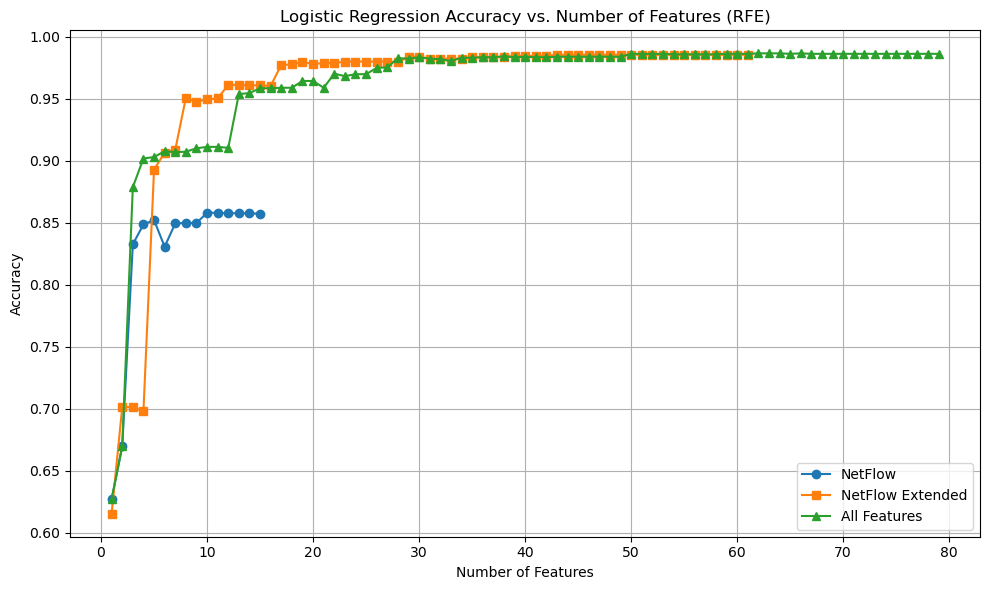

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load all three result CSVs
netflow_df = pd.read_csv("logreg_rfe_backwards_netflow.csv")
extended_df = pd.read_csv("logreg_rfe_backwards_netflow_extended.csv")
all_df = pd.read_csv("logreg_rfe_backwards_all_features.csv")

# Sort each by Num_Features
netflow_df.sort_values("Num_Features", inplace=True)
extended_df.sort_values("Num_Features", inplace=True)
all_df.sort_values("Num_Features", inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(netflow_df["Num_Features"], netflow_df["Accuracy"], label="NetFlow", marker='o')
plt.plot(extended_df["Num_Features"], extended_df["Accuracy"], label="NetFlow Extended", marker='s')
plt.plot(all_df["Num_Features"], all_df["Accuracy"], label="All Features", marker='^')
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs. Number of Features (RFE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


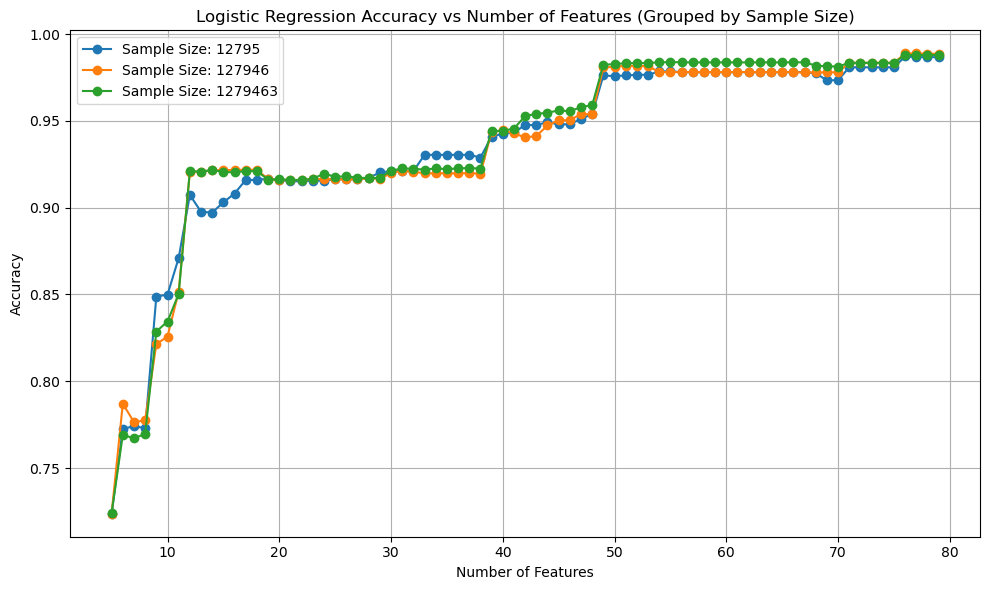

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your results
df = pd.read_csv("logistic_regression_feature_comparison_incremental.csv")

# Sort by sample size and feature count for smooth curves
df.sort_values(by=["Sample_Size", "Num_Features"], inplace=True)

# Plot Accuracy vs Num_Features for each unique Sample_Size
plt.figure(figsize=(10, 6))

for sample_size in df["Sample_Size"].unique():
    subset = df[df["Sample_Size"] == sample_size]
    plt.plot(subset["Num_Features"], subset["Accuracy"], marker='o', label=f"Sample Size: {sample_size}")

plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs Number of Features (Grouped by Sample Size)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


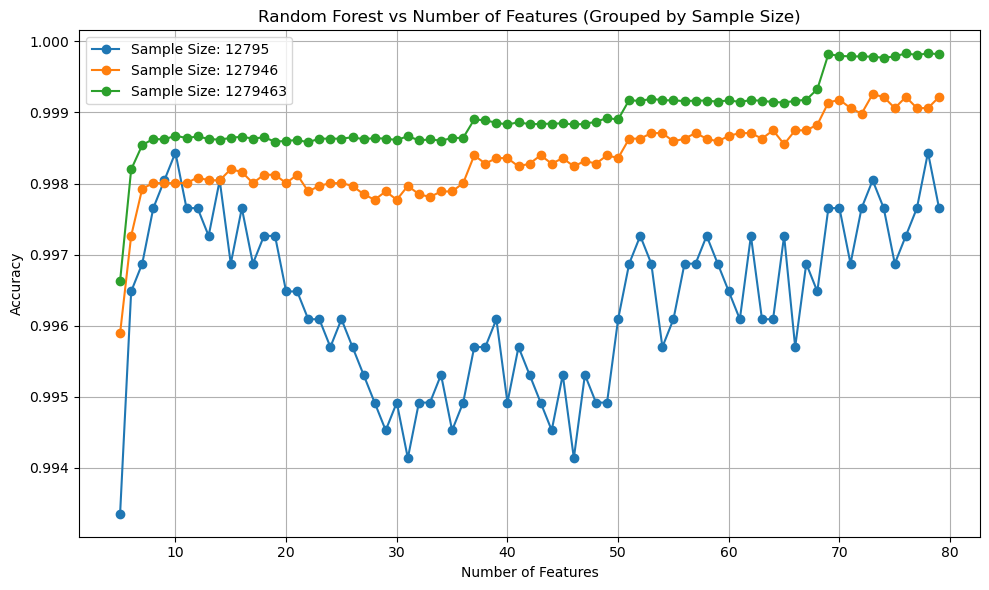

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your results
df = pd.read_csv("random_forest_feature_comparison_incremental.csv")

# Sort by sample size and feature count for smooth curves
df.sort_values(by=["Sample_Size", "Num_Features"], inplace=True)

# Plot Accuracy vs Num_Features for each unique Sample_Size
plt.figure(figsize=(10, 6))

for sample_size in df["Sample_Size"].unique():
    subset = df[df["Sample_Size"] == sample_size]
    plt.plot(subset["Num_Features"], subset["Accuracy"], marker='o', label=f"Sample Size: {sample_size}")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Random Forest vs Number of Features (Grouped by Sample Size)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
